In [151]:
import os
os.chdir('/home/evlasova/covid-t-cell-classifier')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from source.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_cluster_map, \
                            plot_clustermap_axes_based
from source.usage_matrix_preprocessing import prepare_usage_matrix
from source.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, cross_validation_between_batches, make_hla_predictor
from source.data_utils import prepare_run_column
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm

from source.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing

genes_with_deletion = ['TRBV27', 'TRBV28', 'TRBV12-3', 'TRBV4-1', 'TRBV5-1', 'TRBV6-1', 'TRBV3-2', 'TRBV6-2', 'TRBV7-2', 'TRBV10-2', 'TRBV4-3']

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import fisher_exact, chi2_contingency
from multipy.fwer import sidak, hochberg
import random

import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("source.viz_utils")
importlib.reload(imported_module)

<module 'source.viz_utils' from '/home/evlasova/covid-t-cell-classifier/source/viz_utils.py'>

# Raw data prep

In [4]:
fmba_desc = pd.read_csv('data/desc_fmba_not_nan_hla.csv').drop(columns=['Unnamed: 0'])
fmba_desc['run'] = fmba_desc['run'].apply(lambda x: x.split('.')[0])
fmba_desc = fmba_desc[['run', 'folder', 'COVID_status']]
fmba_desc = fmba_desc[fmba_desc.COVID_status != 'unknown'].replace({'precovid': 'healthy'})
fmba_desc.folder = fmba_desc.folder.apply(lambda x: x.split('_')[2])
fmba_desc

,run,folder,COVID_status
0,020000010808_S3_L001,NovaSeq5,COVID
1,020000110808_S14_L001,NovaSeq,COVID
2,020000190808_S27_L001,NovaSeq5,COVID
3,020000200808_S181_L002,NovaSeq5,healthy
4,020000280808_S59_L001,NovaSeq5,COVID
...,...,...,...
963,780008510808_S152_L002,NovaSeq3,COVID
964,780008550808_S150_L002,NovaSeq3,COVID
965,910000140808_S123_L002,NovaSeq2,COVID
966,910000320808_S121_L002,NovaSeq2,COVID


# Re-batched data prep

In [38]:
full = pd.read_csv('data/fmba_2021.txt', sep='\t')
full = full[full['file.name'].str.contains('TRB')]
full.COVID_status.value_counts()

COVID       761
healthy     376
precovid    103
unknown      24
Name: COVID_status, dtype: int64

In [5]:
fmba_desc_fixed = pd.read_csv('data/desc_fmba_new_split.csv').drop(columns=['Unnamed: 0'])
fmba_desc_fixed['run'] = fmba_desc_fixed['run'].apply(lambda x: x.split('.')[0])
fmba_desc_fixed = fmba_desc_fixed[['run', 'folder', 'COVID_status']]
fmba_desc_fixed = fmba_desc_fixed[fmba_desc_fixed.COVID_status != 'unknown'].replace({'precovid': 'healthy'})
fmba_desc_fixed.folder = fmba_desc_fixed.folder.apply(lambda x: x.split('_')[2] if '_' in x else x)
fmba_desc_fixed

,run,folder,COVID_status
0,020000010808_S3_L001,NovaSeq5,COVID
1,020000110808_S14_L001,NovaSeq14,COVID
2,020000190808_S27_L001,NovaSeq5,COVID
3,020000200808_S181_L002,NovaSeq5,healthy
4,020000280808_S59_L001,NovaSeq5,COVID
...,...,...,...
951,780008510808_S152_L002,NovaSeq34,COVID
952,780008550808_S150_L002,NovaSeq34,COVID
953,910000140808_S123_L002,NovaSeq24,COVID
954,910000320808_S121_L002,NovaSeq24,COVID


In [29]:
fmba_desc_fixed.COVID_status.value_counts()

COVID      661
healthy    295
Name: COVID_status, dtype: int64

# Biological biases PCA, β chain samples

In [6]:
um_norm = pd.read_csv('data/normalized_usage_matrix.csv').drop(columns=['Unnamed: 0'])
um_stand_log_exp = pd.read_csv('data/standardized_log_exp_usage_matrix_by_joint_new.csv').drop(columns=['Unnamed: 0']).fillna(0)

In [7]:
um_norm.run = um_norm.run.apply(lambda x: x.split('.')[0])
um_norm = um_norm.merge(fmba_desc)
um_norm

,run,project,covid,hla,number_of_clonotypes,TRBV11-1,TRBV28,TRBV4-2,TRBV6-3,TRBV5-6,...,TRBV7-3,TRBV12-5,TRBV3-1,TRBV7-6,TRBV5-3,TRBV5-8,TRBV5-4,TRBV9,folder,COVID_status
0,020000010808_S3_L001,2020/10_FMBA_NovaSeq5,covid,A*24:02,4324,0.001619,0.014107,0.014339,0.000000,0.014339,...,0.017345,0.007632,0.020583,0.012488,0.004163,0.010407,0.018039,0.039084,NovaSeq5,COVID
1,020000110808_S14_L001,2020/09_FMBA_NovaSeq_DNA,covid,A*11:01,13264,0.003920,0.048402,0.013872,0.000000,0.017642,...,0.023221,0.006484,0.024729,0.012440,0.002790,0.005353,0.022919,0.036037,NovaSeq,COVID
2,020000190808_S27_L001,2020/10_FMBA_NovaSeq5,covid,A*32:01,16977,0.003181,0.045886,0.013253,0.000059,0.017141,...,0.023856,0.005360,0.024150,0.012134,0.003357,0.005125,0.018142,0.035106,NovaSeq5,COVID
3,020000200808_S181_L002,2020/10_FMBA_NovaSeq5,healthy,A*11:01,14220,0.002813,0.069972,0.017370,0.000000,0.020816,...,0.021941,0.002883,0.028622,0.009564,0.003516,0.006892,0.015541,0.041350,NovaSeq5,healthy
4,020000280808_S59_L001,2020/10_FMBA_NovaSeq5,covid,A*02:01,6144,0.005697,0.037109,0.013835,0.000000,0.022949,...,0.017578,0.005046,0.022786,0.008952,0.002279,0.004720,0.016113,0.028809,NovaSeq5,COVID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,780008510808_S152_L002,2020/09_FMBA_NovaSeq3_DNA,covid,A*11:01,7215,0.003188,0.052807,0.011227,0.000000,0.018572,...,0.010672,0.006376,0.007623,0.013306,0.003188,0.007900,0.015939,0.032848,NovaSeq3,COVID
952,780008550808_S150_L002,2020/09_FMBA_NovaSeq3_DNA,covid,A*25:01,8864,0.002820,0.012974,0.014666,0.000000,0.018840,...,0.018502,0.006769,0.028768,0.011958,0.002708,0.006882,0.018502,0.036891,NovaSeq3,COVID
953,910000140808_S123_L002,2020/09_FMBA_NovaSeq2_DNA,covid,A*02:01,27443,0.002259,0.081769,0.013446,0.000000,0.018548,...,0.015414,0.005138,0.019714,0.009656,0.002952,0.005575,0.017564,0.036439,NovaSeq2,COVID
954,910000320808_S121_L002,2020/09_FMBA_NovaSeq2_DNA,covid,A*33:01,11451,0.002009,0.057724,0.012925,0.000000,0.022618,...,0.007336,0.005065,0.007947,0.010130,0.002009,0.008908,0.019212,0.021832,NovaSeq2,COVID


In [8]:
um_stand_log_exp.run = um_stand_log_exp.run.apply(lambda x: x.split('.')[0])
um_stand_log_exp = um_stand_log_exp.merge(fmba_desc)

In [9]:
um_stand_log_exp

,run,project,covid,TRBV17,TRBV19,TRBV5-5,TRBV24-1,TRBV7-2,TRBV27,TRBV10-1,...,TRBV11-1,TRBV3-1,TRBV12-4,TRBV7-5,TRBV7-9,TRBV5-1,TRBV9,TRBV30,folder,COVID_status
0,020000010808_S3_L001,2020/10_FMBA_NovaSeq5,covid,0.000012,0.077090,0.015560,0.009445,0.006132,0.019823,0.011908,...,0.001227,0.007025,0.021753,0.000872,0.013907,0.099362,0.044912,0.030859,NovaSeq5,COVID
1,020000190808_S27_L001,2020/10_FMBA_NovaSeq5,covid,0.000012,0.062107,0.005195,0.022627,0.039527,0.042169,0.005039,...,0.003812,0.008593,0.040857,0.001137,0.053298,0.030081,0.037223,0.030440,NovaSeq5,COVID
2,020000200808_S181_L002,2020/10_FMBA_NovaSeq5,healthy,0.000012,0.047003,0.006595,0.018216,0.042055,0.028792,0.007176,...,0.003245,0.010046,0.031251,0.001505,0.044168,0.055717,0.049578,0.032140,NovaSeq5,healthy
3,020000280808_S59_L001,2020/10_FMBA_NovaSeq5,covid,0.000012,0.077687,0.008817,0.005243,0.040572,0.038940,0.009828,...,0.006090,0.008054,0.035458,0.000956,0.034181,0.038420,0.021578,0.031928,NovaSeq5,COVID
4,020000340808_S82_L001,2020/10_FMBA_NovaSeq5,covid,0.000012,0.082899,0.010652,0.022292,0.013055,0.030045,0.006799,...,0.003435,0.011758,0.036966,0.001023,0.041705,0.087677,0.044237,0.003007,NovaSeq5,COVID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,780003510808_S92_L001,2020/10_FMBA_NovaSeq4,healthy,0.000012,0.040773,0.007581,0.026620,0.056588,0.019811,0.011405,...,0.001586,0.009462,0.043989,0.000850,0.047989,0.040428,0.027970,0.024054,NovaSeq4,healthy
952,780003520808_S12_L001,2020/10_FMBA_NovaSeq4,healthy,0.000012,0.070209,0.016534,0.012030,0.016194,0.043445,0.014116,...,0.002527,0.011657,0.028845,0.000957,0.038734,0.088822,0.010087,0.024623,NovaSeq4,healthy
953,780003890808_S35_L001,2020/10_FMBA_NovaSeq4,healthy,0.000012,0.033553,0.010997,0.004484,0.046968,0.052109,0.003266,...,0.002046,0.007950,0.046342,0.000847,0.014613,0.042309,0.019986,0.026628,NovaSeq4,healthy
954,780003930808_S76_L001,2020/10_FMBA_NovaSeq4,healthy,0.000012,0.084085,0.015545,0.026300,0.039274,0.057862,0.010076,...,0.003005,0.006193,0.000051,0.000460,0.011507,0.061132,0.032113,0.031944,NovaSeq4,healthy


In [41]:
um_norm.folder = um_norm.folder.apply(lambda x: x.split('_')[2] if '_' in x else x)
um_stand_log_exp.folder = um_stand_log_exp.folder.apply(lambda x: x.split('_')[2] if '_' in x else x)
um_norm['NovaSeq'] = um_norm_alpha.folder
um_stand_log_exp['NovaSeq'] = um_stand_log_exp.folder

In [125]:
um_norm

,run,project,covid,hla,number_of_clonotypes,TRBV11-1,TRBV28,TRBV4-2,TRBV6-3,TRBV5-6,...,TRBV12-5,TRBV3-1,TRBV7-6,TRBV5-3,TRBV5-8,TRBV5-4,TRBV9,folder,COVID_status,NovaSeq
0,020000010808_S3_L001,2020/10_FMBA_NovaSeq5,covid,A*24:02,4324,0.001619,0.014107,0.014339,0.000000,0.014339,...,0.007632,0.020583,0.012488,0.004163,0.010407,0.018039,0.039084,NovaSeq5,COVID,NovaSeq5
1,020000110808_S14_L001,2020/09_FMBA_NovaSeq_DNA,covid,A*11:01,13264,0.003920,0.048402,0.013872,0.000000,0.017642,...,0.006484,0.024729,0.012440,0.002790,0.005353,0.022919,0.036037,NovaSeq,COVID,NovaSeq
2,020000190808_S27_L001,2020/10_FMBA_NovaSeq5,covid,A*32:01,16977,0.003181,0.045886,0.013253,0.000059,0.017141,...,0.005360,0.024150,0.012134,0.003357,0.005125,0.018142,0.035106,NovaSeq5,COVID,NovaSeq5
3,020000200808_S181_L002,2020/10_FMBA_NovaSeq5,healthy,A*11:01,14220,0.002813,0.069972,0.017370,0.000000,0.020816,...,0.002883,0.028622,0.009564,0.003516,0.006892,0.015541,0.041350,NovaSeq5,healthy,NovaSeq5
4,020000280808_S59_L001,2020/10_FMBA_NovaSeq5,covid,A*02:01,6144,0.005697,0.037109,0.013835,0.000000,0.022949,...,0.005046,0.022786,0.008952,0.002279,0.004720,0.016113,0.028809,NovaSeq5,COVID,NovaSeq5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,780008510808_S152_L002,2020/09_FMBA_NovaSeq3_DNA,covid,A*11:01,7215,0.003188,0.052807,0.011227,0.000000,0.018572,...,0.006376,0.007623,0.013306,0.003188,0.007900,0.015939,0.032848,NovaSeq3,COVID,NovaSeq3
952,780008550808_S150_L002,2020/09_FMBA_NovaSeq3_DNA,covid,A*25:01,8864,0.002820,0.012974,0.014666,0.000000,0.018840,...,0.006769,0.028768,0.011958,0.002708,0.006882,0.018502,0.036891,NovaSeq3,COVID,NovaSeq3
953,910000140808_S123_L002,2020/09_FMBA_NovaSeq2_DNA,covid,A*02:01,27443,0.002259,0.081769,0.013446,0.000000,0.018548,...,0.005138,0.019714,0.009656,0.002952,0.005575,0.017564,0.036439,NovaSeq2,COVID,NovaSeq2
954,910000320808_S121_L002,2020/09_FMBA_NovaSeq2_DNA,covid,A*33:01,11451,0.002009,0.057724,0.012925,0.000000,0.022618,...,0.005065,0.007947,0.010130,0.002009,0.008908,0.019212,0.021832,NovaSeq2,COVID,NovaSeq2


<AxesSubplot:>

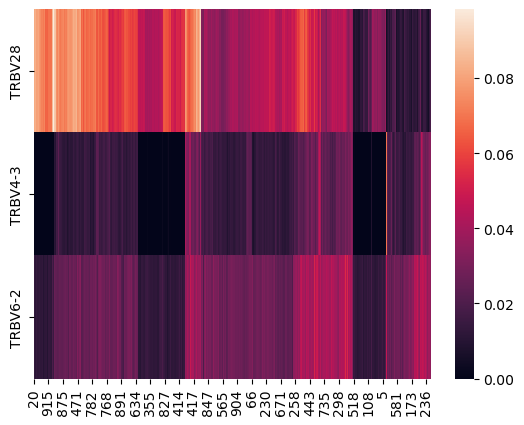

In [149]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

genes = ['TRBV28', 'TRBV4-3', 'TRBV6-2']
Z = linkage(um_norm[genes], 'complete')
labels = fcluster(Z, 0.00001, criterion='distance')
labels_order = np.argsort(labels)
sns.heatmap(um_norm.loc[labels_order, :][genes].T)

# α chain PCA before/after batch effect fixing

In [14]:
um_norm_alpha = pd.read_csv('data/normalized_usage_matrix_alpha_fmba.csv').drop(columns=['Unnamed: 0', 'sum'])
um_stand_alpha = pd.read_csv('data/standardized_log_exp_usage_matrix_by_v_gene_alpha_fmba.csv').drop(columns=['Unnamed: 0'])

In [15]:
um_norm_alpha.run = um_norm_alpha.run.apply(lambda x: x.split('.')[0])
um_stand_alpha.run = um_stand_alpha.run.apply(lambda x: x.split('.')[0])
um_norm_alpha = um_norm_alpha.merge(fmba_desc)
um_stand_alpha = um_stand_alpha.merge(fmba_desc)
um_norm_alpha.folder = um_norm_alpha.folder.apply(lambda x: x.split('_')[2] if '_' in x else x)
um_stand_alpha.folder = um_stand_alpha.folder.apply(lambda x: x.split('_')[2] if '_' in x else x)

In [16]:
um_norm_alpha['NovaSeq'] = um_norm_alpha.folder
um_stand_alpha['NovaSeq'] = um_stand_alpha.folder

# plotting

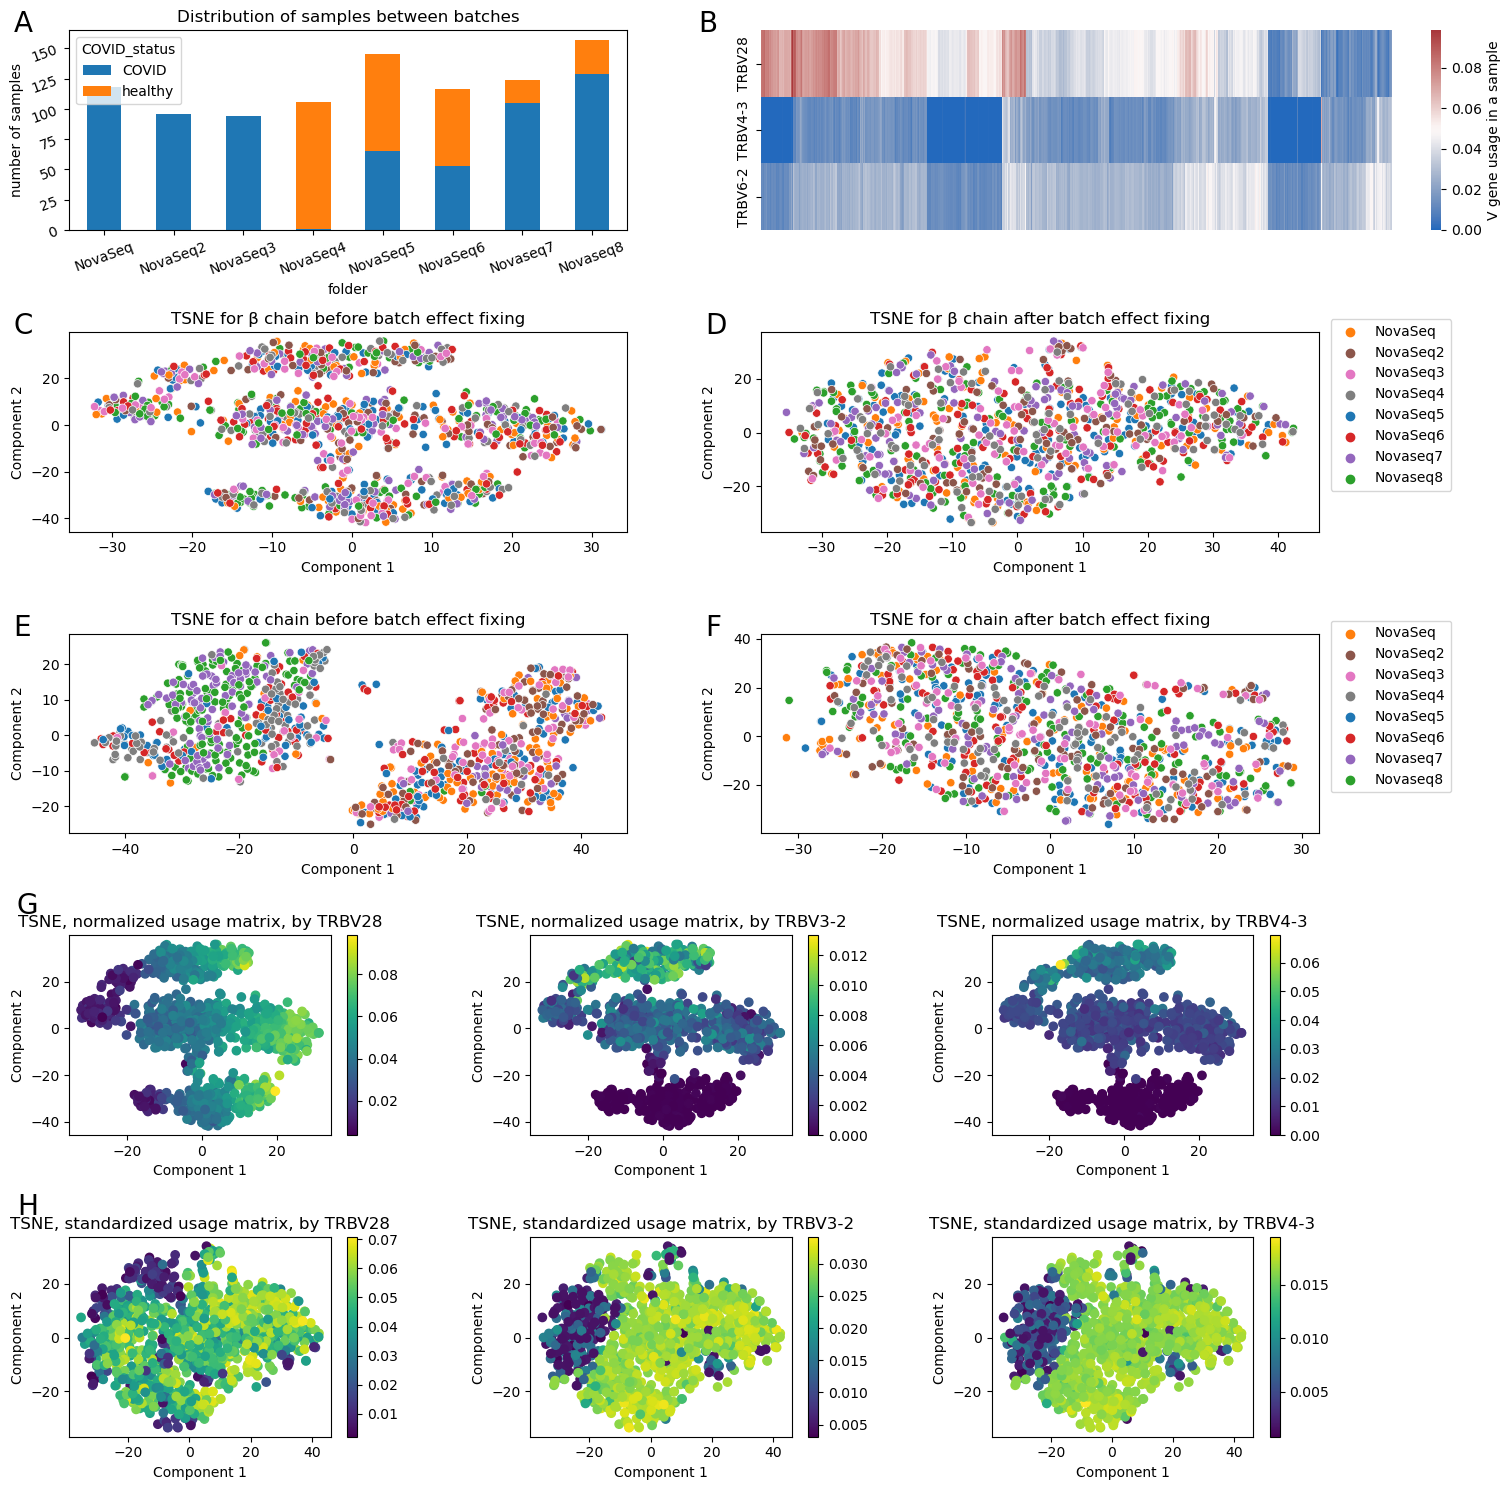

In [159]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(18, 15))
gs = GridSpec(nrows=5, 
              ncols=8)
font_size=20
delta_x=-0.1
delta_y=1.1

##############################################################################

ax0 = fig.add_subplot(gs[0, :3])
fmba_desc.groupby(['folder', 'COVID_status'], as_index=False).count().pivot(index='folder', 
                                                                            columns='COVID_status', 
                                                                            values='run').fillna(0).plot(kind='bar', stacked=True, ax=ax0)
ax0.set_ylabel('number of samples')
ax0.set_title('Distribution of samples between batches')
ax0.tick_params(labelrotation=20)
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)

##############################################################################

ax1 = fig.add_subplot(gs[0, 3:7])
plot_clustermap_axes_based(um_norm, genes=['TRBV28', 'TRBV4-3', 'TRBV6-2'], ax=ax1)
ax1.text(delta_x, delta_y, 'B',
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax1.transAxes,
         size=font_size)   

##############################################################################

ax10 = fig.add_subplot(gs[1, :3])
plot_usage_matrix_pca(um_norm, target='NovaSeq', ax=ax10, method=TSNE)
ax10.set_title('TSNE for β chain before batch effect fixing')
ax10.legend([],[], frameon=False)
ax10.text(delta_x, delta_y, 'C',
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax10.transAxes,
         size=font_size)        

##############################################################################

ax11 = fig.add_subplot(gs[1, 3:6])
plot_usage_matrix_pca(um_stand_log_exp, target='NovaSeq', ax=ax11, method=TSNE)
ax11.set_title('TSNE for β chain after batch effect fixing')
ax11.text(delta_x, delta_y, 'D',
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax11.transAxes,
         size=font_size)
handles, labels = ax11.get_legend_handles_labels()
pairs = [(x, y) for x, y in zip(handles, labels)]
pairs.sort(key=lambda x: x[1])
ax11.legend([x[0] for x in pairs],[x[1] for x in pairs]) 
sns.move_legend(ax11, "upper right", bbox_to_anchor=(1.25, 1.1))

##############################################################################

ax8 = fig.add_subplot(gs[2, :3])
plot_usage_matrix_pca(um_norm_alpha, target='NovaSeq', ax=ax8, method=TSNE)
ax8.set_title('TSNE for α chain before batch effect fixing')
ax8.legend([],[], frameon=False)
ax8.text(delta_x, delta_y, 'E',
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax8.transAxes,
         size=font_size)        

##############################################################################

ax9 = fig.add_subplot(gs[2, 3:6])
plot_usage_matrix_pca(um_stand_alpha, target='NovaSeq', ax=ax9, method=TSNE)
ax9.set_title('TSNE for α chain after batch effect fixing')
ax9.text(delta_x, delta_y, 'F',
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax9.transAxes,
         size=font_size)
handles, labels = ax9.get_legend_handles_labels()
pairs = [(x, y) for x, y in zip(handles, labels)]
pairs.sort(key=lambda x: x[1])
ax9.legend([x[0] for x in pairs],[x[1] for x in pairs]) 
sns.move_legend(ax9, "upper right", bbox_to_anchor=(1.25, 1.1))

##############################################################################

for i, v_gene in enumerate(['TRBV28', 'TRBV3-2', 'TRBV4-3']):
    ax_i = fig.add_subplot(gs[3, 2 * i: 2 * i + 2])
    plot_usage_matrix_pca(um_norm, target=v_gene, plot_gradient=True, ax=ax_i, method=TSNE)
    ax_i.set_title(f'TSNE, normalized usage matrix, by {v_gene}')
    if i == 0:
        ax_i.text(delta_x-0.1, delta_y+0.12, 'G',
         horizontalalignment='left',
         verticalalignment='top',
        transform=ax_i.transAxes,
        size=font_size)

##############################################################################
        
for i, v_gene in enumerate(['TRBV28', 'TRBV3-2', 'TRBV4-3']):
    ax_i = fig.add_subplot(gs[4, 2 * i: 2 * i + 2])
    plot_usage_matrix_pca(um_stand_log_exp, target=v_gene, plot_gradient=True, ax=ax_i, method=TSNE)
    ax_i.set_title(f'TSNE, standardized usage matrix, by {v_gene}')
    if i == 0:
        ax_i.text(delta_x-0.1, delta_y+0.12, 'H',
         horizontalalignment='left',
         verticalalignment='top',
        transform=ax_i.transAxes,
        size=font_size)
        
##############################################################################

        
plt.tight_layout()
plt.savefig("figures/fig1.svg")
plt.savefig("figures/fig1.pdf")
plt.savefig("figures/fig1.png")
plt.show()

Figure 1. FMBA data overview.

A. Initial distribution of samples in batches of data.

B. Distribution of samples in batches after merging NovaSeq4 into batches 1-3.

C. Biological effect of gene deletions for TRBV genes. TSNE made for data before applying batch effect fixing procedure.

D. Biological effects remain visible after batch effect fixing procedure application.

E. Visible batch effect is present for TRAV based TSNE plot.

F. TSNE for α chain V genes after batch effect fixing procedure application.